In [1]:
using  DataFrames, Distributions, Extremes, Gadfly, Random, StatsBase
import Cairo, Fontconfig

In [2]:
"""
    generate_ARMAX(α::Real, n::Int)

Generate `n` realizations of the ARMAX process with parameter `α`
"""
function generate_ARMAX(α::Real, n::Int)
   @assert 0 ≤ α < 1 
    
    z = rand(GeneralizedExtremeValue(0,1,1), n)
    
    x = similar(z)
    
    x[1] = z[1]
    
    for i in 2:length(z)
       x[i] = max(α*x[i-1], (1-α)*z[i]) 
    end
    
    return x
    
end

generate_ARMAX

In [3]:
"""
    runs_method(data::AbstractVector{<:Real}, u::Real, r::Int)

Estimate the extremal index using the runs method with threshold `u` and runlength `r`

## Details

Parameters:
    - data: Vector of observed values.
    - u: Threshold above which values are considered extreme.
    - r: Run parameter (minimum separation for declustering).

Returns:
    - Estimated extremal index.
"""
function runs_method(data::AbstractVector{<:Real}, u::Real, r::Int)
    
    exceedances = data .> u  # Indicator vector for exceedances
    clusters = 0
    i = 1
    n = length(data)

    while i <= n
        if exceedances[i]
            clusters += 1
            i += r  # Skip ahead by r to decluster
        else
            i += 1
        end
    end

    nu = sum(exceedances)  # Total number of exceedances
    return nu == 0 ? NaN : clusters / nu  # Avoid division by zero
end

runs_method

In [4]:
"""
    runlength_acf(data::AbstractVector{<:Real}, u::Real, max_lag=10)

Compute the autorcorrelation of the exceeddances above the threshold u
"""
function runlength_acf(data::AbstractVector{<:Real}, u::Real, max_lag=10)
    
    exceedances = data[data .> u]  # Indicator vector
    
    r = 1:max_lag
    
    acf_vals = autocor(exceedances, r)
    
    df = DataFrame(Runlength=r, Correlation = acf_vals)
    
    return df
    
end

runlength_acf

# Génération de données stationnaires avec le processus ARMAX

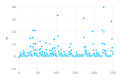

In [5]:
Random.seed!(12345)  # Set seed for reproducibility

# Niveau de la dépendance
α = .5

data = generate_ARMAX(α, 250)

set_default_plot_size(12cm, 8cm)
fig = plot(y=data)

# draw(PDF("data.pdf"), fig)

# Affichage des excédents au-dessus du seuil u

In [6]:
u = 15.

15.0

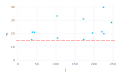

In [7]:
df = DataFrame(i=1:length(data), y = data)

allowmissing!(df, :y)
df.y[df.y.< u] .= missing

set_default_plot_size(12cm, 8cm)

fig = plot(df, x=:i, y=:y, Geom.point,
    yintercept=[u], Geom.hline(color="red", style=:dash))

# draw(PDF("exceedences.pdf"), fig)

# Estimation de l'indice extremal

In [8]:
# Définition du runlength
r = 8

θ̂ = runs_method(data, u, r)

0.5

# Choix du runlength r

### 1. En fonction de la stabilité de l'indice extrémal estimée

In [9]:
df = DataFrame(Runlength=Int64[], θ̂=Float64[])

for r in 1:10
   push!(df, [r, runs_method(data, u ,r)]) 
end

df

Row,Runlength,θ̂
,Int64,Float64
1,1,1.0
2,2,0.75
3,3,0.666667
4,4,0.666667
5,5,0.666667
6,6,0.583333
7,7,0.583333
8,8,0.5
9,9,0.5


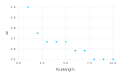

In [10]:
set_default_plot_size(12cm, 8cm)

fig = plot(df, x=:Runlength, y=:θ̂)

# draw(PDF("extremal_index_estimates.pdf"), fig)

### 2. En fonction de l'autocorrélation des excédents de seuil

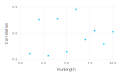

In [11]:
df = runlength_acf(data, u)


set_default_plot_size(12cm, 8cm)

fig = plot(df, x=:Runlength, y=:Correlation)

# draw(PDF("acf.pdf"), fig)


# Calcul de la loi du maximum d'un bloc de taille $n$

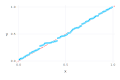

In [12]:
# Taille du bloc
n = 100

# Nombre de blocs
m = 100

Random.seed!(12)

# Génération de réalisations du processus ARMAX
data = generate_ARMAX(.5 ,n*m)

# Extraction du vecteur de maxima
y = vec(maximum(reshape(data,(n, m)), dims=1))
        
# Définition de la loi GEV pour le maximum d'un bloc de taille n (Voir exercice 3 des notes de cours)
pd = GeneralizedExtremeValue(n*(1-α), n*(1-α), 1)

# Calcul des probabilités et des quantiles empiriques
q, p = Extremes.ecdf(y)

# Calcul des probabilité avec le modèle théorique
p̂ = cdf(pd, q)

# Affichage du diagramme des probabilités

fig = plot(x=p, y=p̂, Geom.point,
    Geom.abline(color="red", style=:dash))

# draw(PDF("ppplot.pdf"), fig)